Total classes: 29
Sample classes: ['A', 'B', 'C', 'D', 'E']


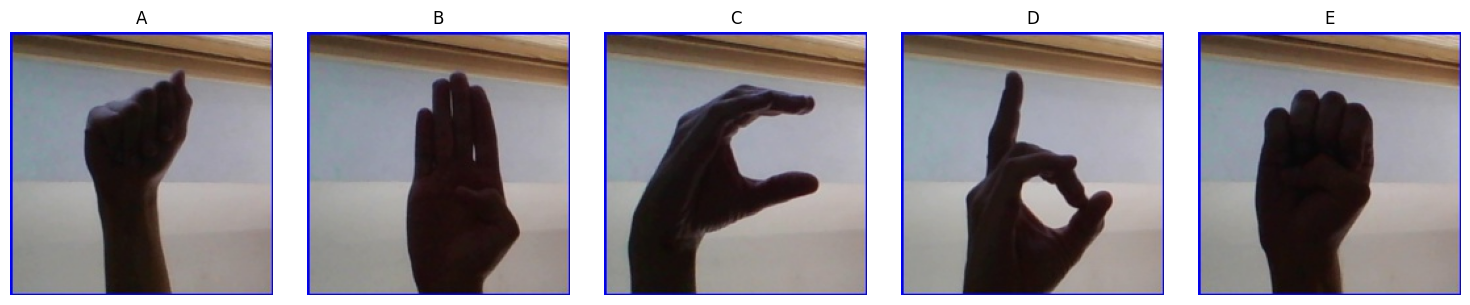

In [2]:
import os
import matplotlib.pyplot as plt
import cv2

# Define the path to the training dataset
train_dir = r'C:\Users\vivek\Desktop\Unified Mentor\Projects-20240722T093004Z-001\Projects\ASL_detection\ASL_detection\archive\asl_alphabet_train'

# List all class folders
classes = sorted(os.listdir(train_dir))
print(f"Total classes: {len(classes)}")
print("Sample classes:", classes[:5])

# Preview a few sample images from different classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, cls in enumerate(classes[:5]):
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 200, 200
BATCH_SIZE = 32

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [4]:
import shutil
import random

# Define paths
subset_dir = r'C:\Users\vivek\Desktop\ASL_subset'
os.makedirs(subset_dir, exist_ok=True)

# Sample 1000 images per class
for cls in classes:
    src_folder = os.path.join(train_dir, cls)
    dst_folder = os.path.join(subset_dir, cls)
    os.makedirs(dst_folder, exist_ok=True)
    
    all_images = os.listdir(src_folder)
    sampled_images = random.sample(all_images, 1000)
    
    for img_name in sampled_images:
        src_path = os.path.join(src_folder, img_name)
        dst_path = os.path.join(dst_folder, img_name)
        shutil.copy2(src_path, dst_path)

print("Subset created with 1000 images per class.")

✅ Subset created with 1000 images per class.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 200, 200
BATCH_SIZE = 32

# Create ImageDataGenerator with augmentation
subset_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

# Load training and validation data from the subset
train_subset = subset_datagen.flow_from_directory(
    subset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_subset = subset_datagen.flow_from_directory(
    subset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 23200 images belonging to 29 classes.
Found 5800 images belonging to 29 classes.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base model without top layers
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(29, activation='softmax')  # 29 ASL classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 29)                3

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('asl_model_best.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    train_subset,
    validation_data=val_subset,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
725/725 [==============================] - 825s 1s/step - loss: 1.6658 - accuracy: 0.5165 - val_loss: 1.1681 - val_accuracy: 0.6824
Epoch 2/20
725/725 [==============================] - 459s 633ms/step - loss: 0.7433 - accuracy: 0.7695 - val_loss: 0.9069 - val_accuracy: 0.7395
Epoch 3/20
725/725 [==============================] - 469s 646ms/step - loss: 0.5620 - accuracy: 0.8231 - val_loss: 0.8097 - val_accuracy: 0.7576
Epoch 4/20
725/725 [==============================] - 461s 636ms/step - loss: 0.4892 - accuracy: 0.8430 - val_loss: 0.7491 - val_accuracy: 0.7733
Epoch 5/20
725/725 [==============================] - 456s 629ms/step - loss: 0.4379 - accuracy: 0.8575 - val_loss: 0.7020 - val_accuracy: 0.7848
Epoch 6/20
725/725 [==============================] - 467s 643ms/step - loss: 0.4028 - accuracy: 0.8690 - val_loss: 0.6792 - val_accuracy: 0.7936
Epoch 7/20
725/725 [==============================] - 461s 635ms/step - loss: 0.3860 - accuracy: 0.8732 - val_loss: 0.7473 - va

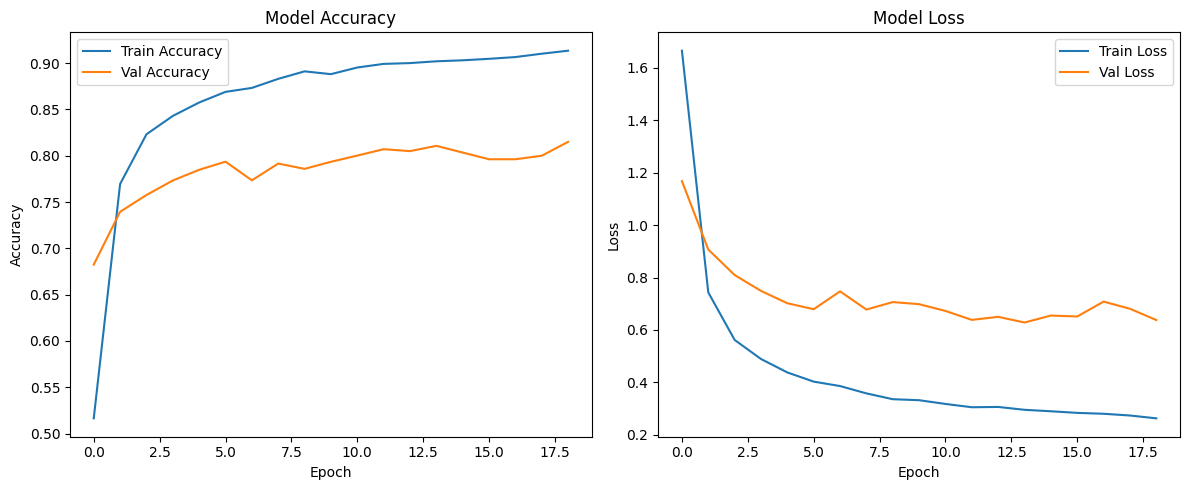

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
!pip install scikit-learn seaborn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ------------------------ --------------- 5.5/8.9 MB 33.6 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 24.0 MB/s eta 0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


182/182 [==============================] - 96s 519ms/step
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.99      0.99       200
           B       0.99      1.00      1.00       200
           C       0.98      0.99      0.99       200
           D       0.99      0.99      0.99       200
           E       0.94      0.96      0.95       200
           F       0.99      1.00      0.99       200
           G       0.98      0.94      0.96       200
           H       0.93      1.00      0.96       200
           I       0.96      0.94      0.95       200
           J       0.99      0.91      0.95       200
           K       0.99      0.99      0.99       200
           L       1.00      0.99      1.00       200
           M       0.93      0.98      0.96       200
           N       0.93      0.93      0.93       200
           O       0.98      0.96      0.97       200
           P       0.91      0.98      0.94       200


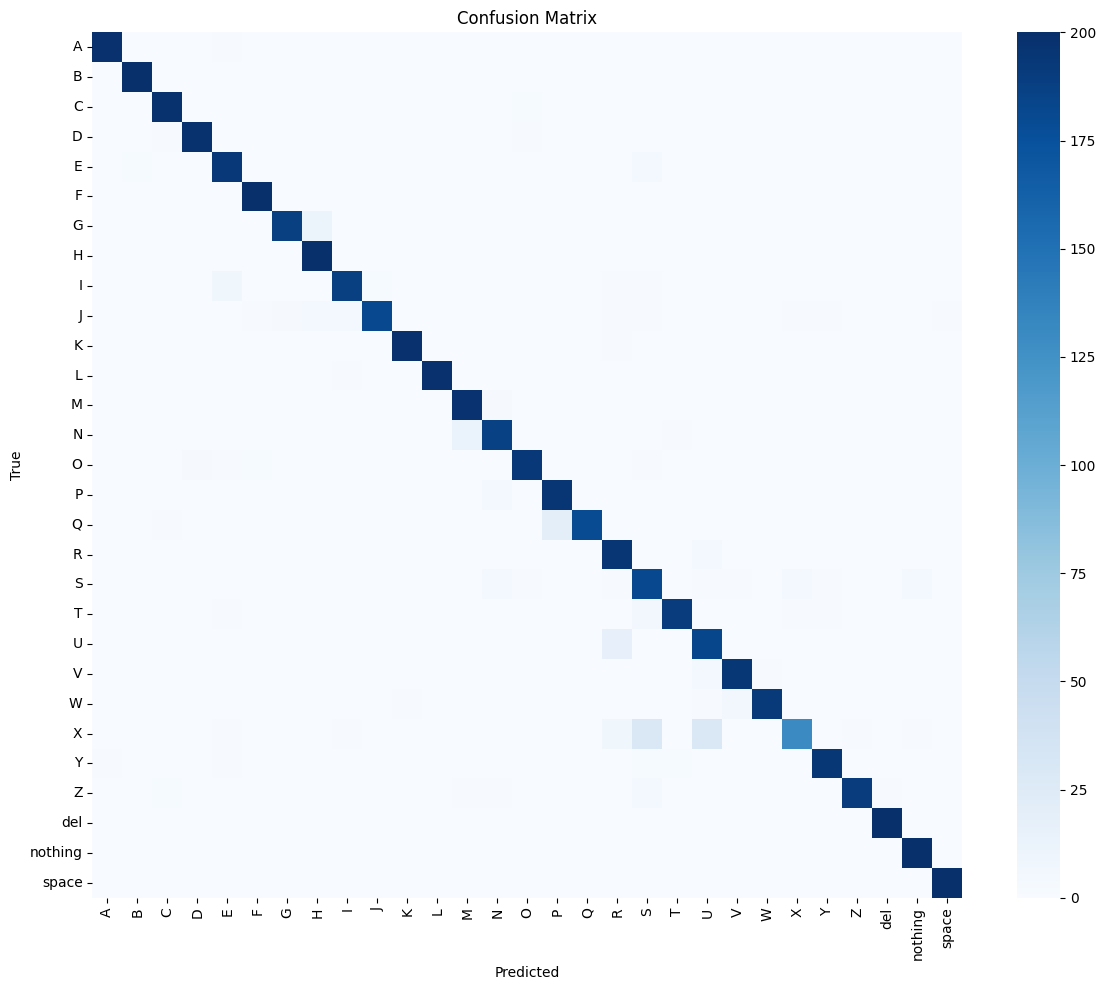

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predict on validation data
val_preds = model.predict(val_subset)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_subset.classes
class_labels = list(val_subset.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

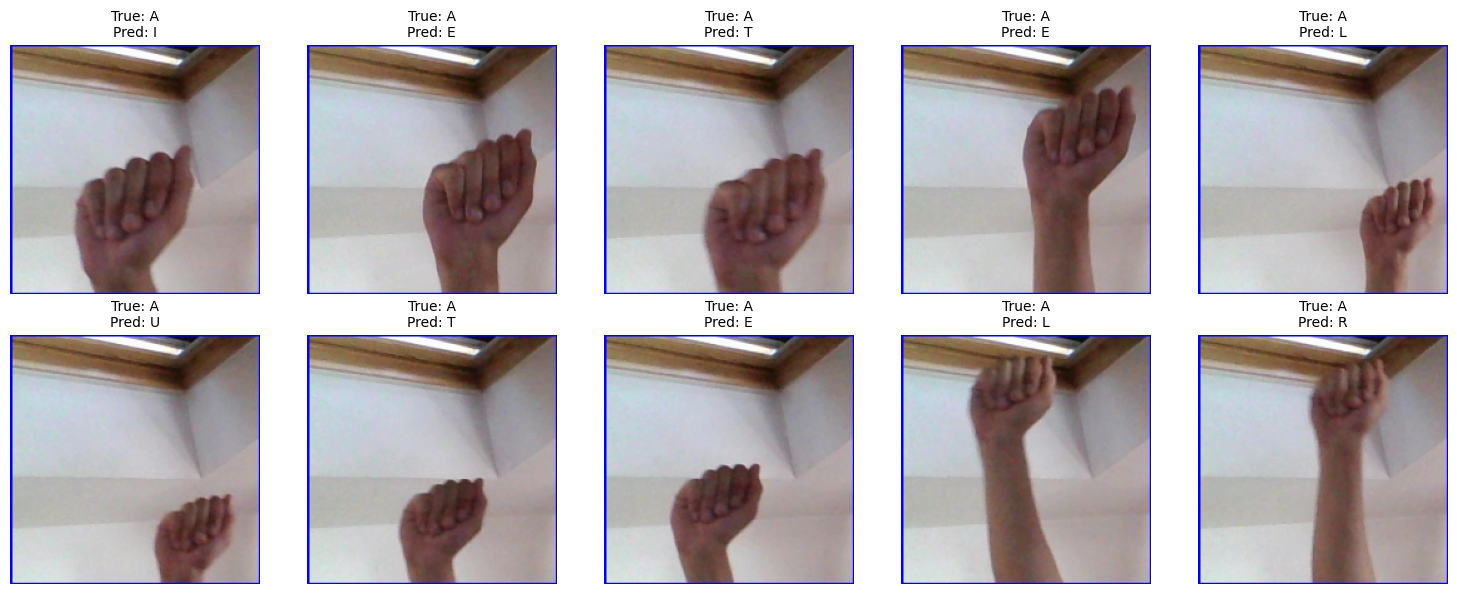

In [12]:
import matplotlib.pyplot as plt

# Get filenames and predicted labels
filenames = val_subset.filepaths
misclassified_indices = [i for i, (pred, true) in enumerate(zip(y_pred, y_true)) if pred != true]

# Show a few misclassified images
num_samples = 10
plt.figure(figsize=(15, 6))
for i, idx in enumerate(misclassified_indices[:num_samples]):
    img = plt.imread(filenames[idx])
    true_label = class_labels[y_true[idx]]
    pred_label = class_labels[y_pred[idx]]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# Unfreeze the base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_subset,
    validation_data=val_subset,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
725/725 [==============================] - 447s 604ms/step - loss: 1.3552 - accuracy: 0.6342 - val_loss: 0.8761 - val_accuracy: 0.7719
Epoch 2/10
725/725 [==============================] - 441s 608ms/step - loss: 0.3912 - accuracy: 0.8673 - val_loss: 0.6915 - val_accuracy: 0.8145
Epoch 3/10
725/725 [==============================] - 450s 620ms/step - loss: 0.2019 - accuracy: 0.9305 - val_loss: 0.4284 - val_accuracy: 0.8728
Epoch 4/10
725/725 [==============================] - 468s 645ms/step - loss: 0.1305 - accuracy: 0.9573 - val_loss: 0.2737 - val_accuracy: 0.9112
Epoch 5/10
725/725 [==============================] - 458s 632ms/step - loss: 0.0883 - accuracy: 0.9701 - val_loss: 0.2315 - val_accuracy: 0.9264
Epoch 6/10
725/725 [==============================] - 463s 639ms/step - loss: 0.0634 - accuracy: 0.9785 - val_loss: 0.2230 - val_accuracy: 0.9328
Epoch 7/10
725/725 [==============================] - 456s 629ms/step - loss: 0.0520 - accuracy: 0.9830 - val_loss: 0.2152 -

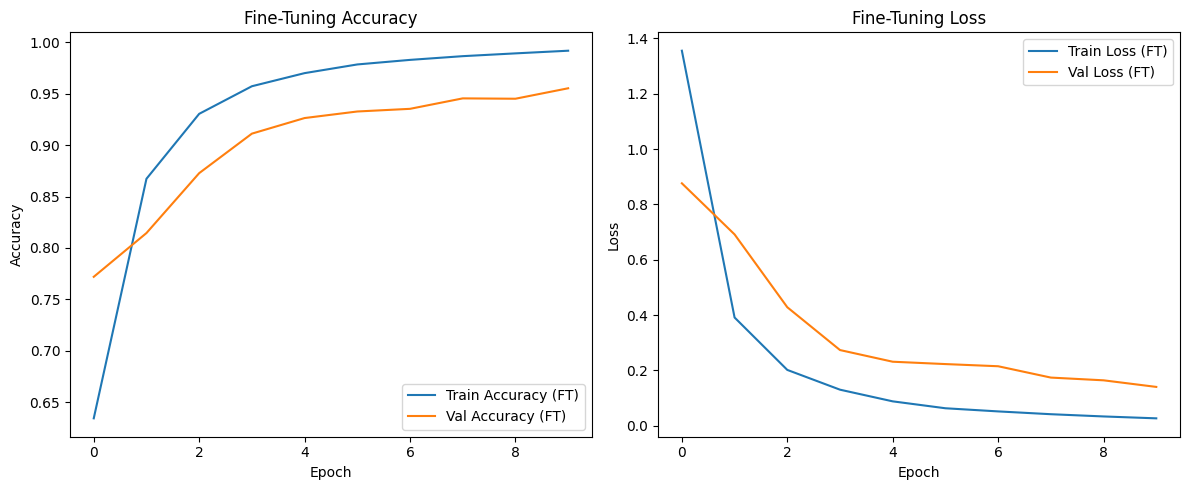

In [14]:
# Plot fine-tuning accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (FT)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy (FT)')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss (FT)')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss (FT)')
plt.title('Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()